In [1]:
import os
import subprocess
from datetime import datetime, timezone

import matplotlib.pyplot as plt
import pandas as pd
from transformers import pipeline

%matplotlib inline

In [2]:
# Sentiment Analysis
#
# Model:   https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english
# Dataset: https://huggingface.co/datasets/stanfordnlp/sst2
#
# - ⚠️ The data is very different from my notes, so the classifier seems heavily
#      biased towards negative label.

os.environ["TOKENIZERS_PARALLELISM"] = "false"

model = "distilbert/distilbert-base-uncased-finetuned-sst-2-english"
revision = "af0f99b"
classifier = pipeline("sentiment-analysis", model=model, revision=revision)

In [3]:
# This should have been a neutral example, but is negative with high
# confidence from this model. My notes have a lot of similar explainers, which
# all end up 🟥.

example = "I like RC"
[{"label": "NEGATIVE", "score": 0.9612146615982056}]

[{'label': 'NEGATIVE', 'score': 0.9612146615982056}]

In [4]:
def ctime(root, path, filename):
    """Guess created timestamp from disk, git and filename"""

    sentinel = datetime.max.replace(tzinfo=timezone.utc)
    file_t, git_t, name_t = (sentinel, sentinel, sentinel)

    file_t = datetime.fromtimestamp(os.stat(path).st_ctime, tz=timezone.utc)

    # Creation time from the oldest commit that introduced the file
    cmd = [
        "git",
        "-C",
        root,
        "log",
        "-100",
        "--format=%ai",
        "--",
        path,
    ]
    try:
        git_ctime_str = subprocess.check_output(cmd).decode("utf-8").split("\n")[-1]
        git_t = datetime.fromisoformat(git_ctime_str)
    except ValueError:
        pass

    formats = ["%Y-%m-%d %H-%M", "%Y-%m-%d"]
    filename = filename.strip(".md").strip()
    for format in formats:
        try:
            # THIS TZ IS DEFINITELY SILLY
            name_t = datetime.strptime(filename, format).replace(tzinfo=timezone.utc)
        except ValueError:
            pass

    # print(f"{file_t=} \n{git_t=} \n{name_t=}")

    return pd.Timestamp(min([file_t, git_t, name_t]))

In [5]:
def read_md_files(directory):
    ignore = {".trash", ".archive", ".obsidian"}

    for root, _, files in os.walk(directory):
        if not any(i in root for i in ignore):
            for file in files:
                if file.endswith(".md") and (not root.startswith(".")):
                    path = os.path.join(root, file)
                    with open(path, "r") as f:
                        yield (
                            {
                                "name": file,
                                "path": path,
                                "contents": f.read(),
                                "ctime": ctime(directory, path, file),
                            }
                        )

In [6]:
def line_sentiment(line):
    sentiment = classifier(line)
    label = sentiment[0]["label"]
    score = sentiment[0]["score"]
    return score if label == "POSITIVE" else -score


def sentiment(r):
    emotions = [line_sentiment(line[0:512]) for line in r.contents.split("\n")]
    emotions = pd.Series(emotions)
    happy = emotions[emotions > 0]
    sad = emotions[emotions < 0]
    return happy.prod() if happy.size > sad.size else sad.prod()

In [7]:
metadata = read_md_files("/Users/j/Work")
df = pd.DataFrame(metadata)
df = df.sort_values(by="ctime")

In [8]:
df["score"] = df.apply(sentiment, axis="columns")

In [9]:
df["ctime"] = pd.DatetimeIndex(df["ctime"], tz="utc").tz_localize(None)
values = df[["ctime", "score"]].set_index("ctime")
values = values.resample("1d").mean()
values

,score
ctime,
2023-03-06,0.283517
2023-03-07,-0.394136
2023-03-08,0.368678
2023-03-09,0.911394
2023-03-10,0.742947
...,...
2024-04-04,NaN
2024-04-05,0.822864
2024-04-06,NaN


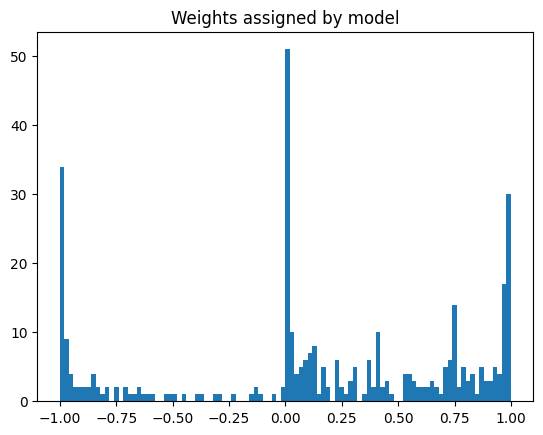

In [10]:
plt.hist(df["score"].to_numpy(), 100)
plt.title("Weights assigned by model");

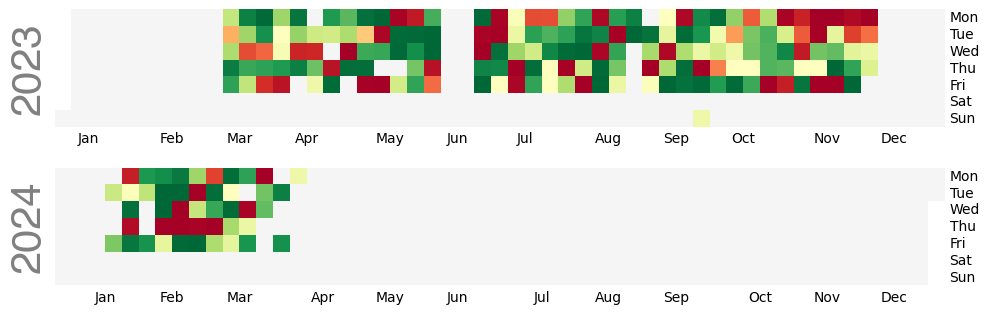

In [11]:
import calplot

calplot.calplot(
    values["score"], linewidth=0, cmap="RdYlGn", colorbar=False, dropzero=True
);

In [12]:
metadata2 = read_md_files("/Users/j/Notes")
df2 = pd.DataFrame(metadata2)
df2 = df2.sort_values(by="ctime")
df2["score"] = df2.apply(sentiment, axis="columns")

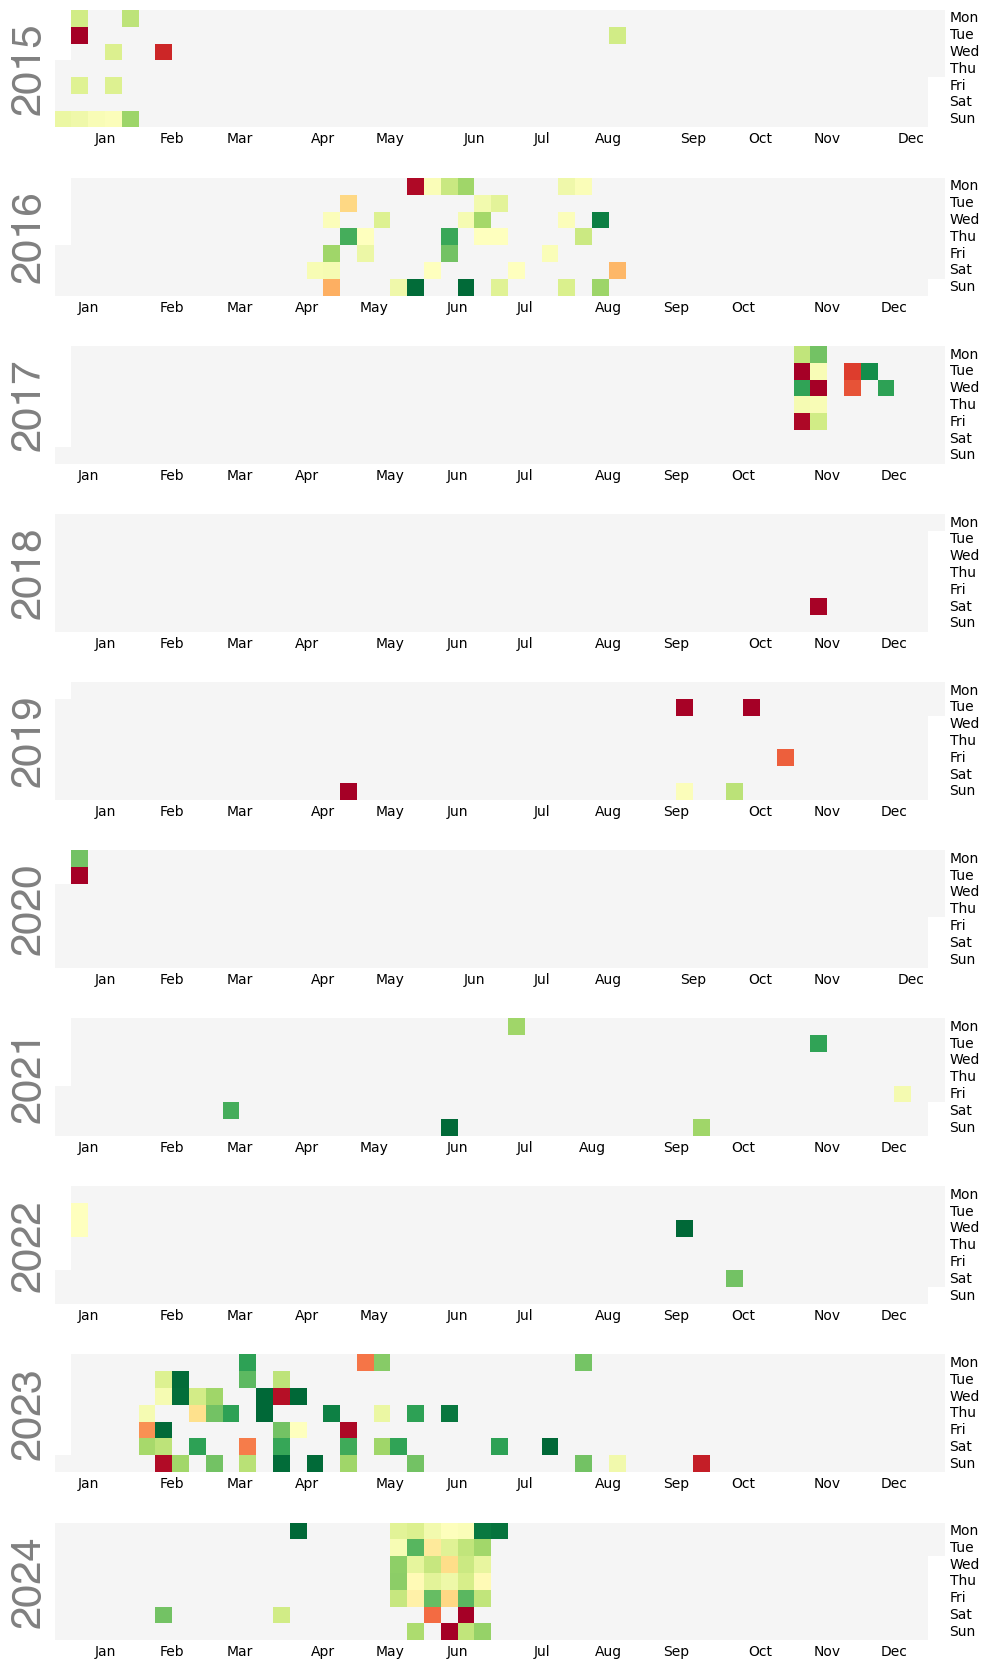

In [13]:
df2["ctime"] = pd.DatetimeIndex(df2["ctime"], tz="utc").tz_localize(None)

values2 = df2[["ctime", "score"]].set_index("ctime")
values2 = values2.resample("1d").mean()
values2.describe()

calplot.calplot(
    values2["score"], linewidth=0, cmap="RdYlGn", colorbar=False, dropzero=True
);